In [ ]:
!pip install pandas python-chess tqdm keras tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=3422196f819cc170b31dfad8ca61d1c5f81d2cc3285d61646758ef077b9cd6d3
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


# Data Loading

In [ ]:
!cp drive/MyDrive/NNUE/lichess_db_eval_1M.jsonl .
!cat lichess_db_eval_1M.jsonl | head -n 10

{"fen":"7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -","evals":[{"pvs":[{"cp":48,"line":"f7g7 e6e2 h8d8 e2d2 b7b5 c4b3 a6a5 a2a3 g7f6 b3a2"}],"knodes":644403,"depth":55},{"pvs":[{"cp":69,"line":"f7g7 e6e2 h8d8 e2d2 b7b5 c4b3 g7f6 d1e1 a6a5 a2a3"},{"cp":163,"line":"h8d8 d1e1 a6a5 a2a3 c6d7 e6e7 f7f6 e1f2 b7b5 c4b3"},{"cp":229,"line":"h8a8 d1e1 a6a5 e6h6 f7g7 h6h4 a8d8 c4d3 c6g2 d3f5"},{"cp":231,"line":"h8f8 d1e1 b7b5 c4b3 a6a5 e6h6 f7g7 h6h4 f8e8 e1f2"},{"cp":237,"line":"h8b8 d1e1 a6a5 e6h6 f7g7 h6h4 b8d8 c4d3 c6g2 d3f5"}],"knodes":4189972,"depth":46}]}
{"fen":"8/4r3/2R2pk1/6pp/3P4/6P1/5K1P/8 b - -","evals":[{"pvs":[{"cp":0,"line":"e7a7 f2e3 a7a3 e3e4 a3a2 h2h4 g5h4 g3h4 a2h2 c6c1"},{"cp":0,"line":"e7b7 f2e3 b7b3 e3e4 b3b2 h2h4 g5h4 g3h4 b2h2 c6c1"}],"knodes":491568,"depth":58},{"pvs":[{"cp":0,"line":"e7e4 h2h4 g5h4 g3h4 e4d4 f2g3 d4g4 g3h3 g4a4 c6c8"},{"cp":0,"line":"g6f5 c6c5 f5e4 h2h4 e4d4 c5f5 e7e5 f5f6 g5g4 f6d6"},{"cp":0,"line":"e7a7 f2e3 a7a1 c6c2 g6f5 e3d3 a1d1 d3e3 d1e1 e3d3"},{

In [ ]:
import pandas as pd

file = "lichess_db_eval_1M.jsonl"

data = pd.read_json(path_or_buf=file, lines=True)

print(data[:10])

                                                 fen  \
0       7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -   
1              8/4r3/2R2pk1/6pp/3P4/6P1/5K1P/8 b - -   
2                     6k1/6p1/8/4K3/4NN2/8/8/8 w - -   
3  r1b2rk1/1p2bppp/p1nppn2/q7/2P1P3/N1N5/PP2BPPP/...   
4                   6k1/4Rppp/8/8/8/8/5PPP/6K1 w - -   
5                    6k1/6p1/6N1/4K3/4N3/8/8/8 b - -   
6  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...   
7                    8/8/2N2k2/8/1p2p3/p7/K7/8 b - -   
8              8/1r6/2R2pk1/6pp/3P4/6P1/5K1P/8 w - -   
9  1R4k1/3q1pp1/6n1/b2p2Pp/2pP2b1/p1P5/P1BQrPPB/5...   

                                               evals  
0  [{'pvs': [{'cp': 48, 'line': 'f7g7 e6e2 h8d8 e...  
1  [{'pvs': [{'cp': 0, 'line': 'e7a7 f2e3 a7a3 e3...  
2  [{'pvs': [{'mate': 15, 'line': 'e5e6 g7g5 f4h5...  
3  [{'pvs': [{'cp': 26, 'line': 'c1e3 f8d8 d1c1 h...  
4  [{'pvs': [{'mate': 1, 'line': 'e7e8'}], 'knode...  
5  [{'pvs': [{'mate': 27, 'line': 'g8h7 e5f5 h7h6... 

In [ ]:
import numpy as np
from tqdm import tqdm

mate_value = 3900
scale = 400.0

def sigmoid(x):
  x = np.asarray(x, dtype=np.float32)
  return 1.0 / (1.0 + np.exp(-x, dtype=np.float32))

data_list = []
data_len = len(data['fen'])

for fen, eval_data in tqdm(zip(data['fen'], data['evals']), total=data_len):
  eval = eval_data[0]['pvs'][0]

  if 'cp' in eval:
    score_eval = float(eval['cp']) / scale
  else:
    mate = int(eval['mate'])
    if mate > 0:
      cp_mate = max(mate_value - ((mate - 1) * 150), 900)
      score_eval = float(cp_mate) / scale
    else:
      cp_mate = min(-mate_value + (abs(mate + 1) * 150), -900)
      score_eval = float(cp_mate) / scale

  res = sigmoid(score_eval)
  data_list.append([fen, res])

print(data_list[:10])

del data

100%|██████████| 1000000/1000000 [00:10<00:00, 97272.86it/s]


[['7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -', np.float32(0.529964)], ['8/4r3/2R2pk1/6pp/3P4/6P1/5K1P/8 b - -', np.float32(0.5)], ['6k1/6p1/8/4K3/4NN2/8/8/8 w - -', np.float32(0.9890131)], ['r1b2rk1/1p2bppp/p1nppn2/q7/2P1P3/N1N5/PP2BPPP/R1BQ1RK1 w - -', np.float32(0.5162443)], ['6k1/4Rppp/8/8/8/8/5PPP/6K1 w - -', np.float32(0.9999417)], ['6k1/6p1/6N1/4K3/4N3/8/8/8 b - -', np.float32(0.9046505)], ['rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq -', np.float32(0.51187277)], ['8/8/2N2k2/8/1p2p3/p7/K7/8 b - -', np.float32(0.5)], ['8/1r6/2R2pk1/6pp/3P4/6P1/5K1P/8 w - -', np.float32(0.5)], ['1R4k1/3q1pp1/6n1/b2p2Pp/2pP2b1/p1P5/P1BQrPPB/5NK1 b - -', np.float32(0.4644352)]]


In [ ]:
print(data_list[317])

['2k1rb1r/ppp3pp/2n5/3B1b2/5P2/2P1BQ2/P2N1P1P/2KR3R b - -', np.float32(5.8291265e-05)]


In [ ]:
import chess
import gc
import numpy as np

def board_to_input(board):
  input_white = []
  input_black = []

  for color in chess.COLORS:
    for piece_type in chess.PIECE_TYPES:
      piece_map = board.pieces(piece_type, color)

      input_white.extend(piece_map.tolist())
      input_black.extend(piece_map.mirror().tolist())

  return np.array(input_white, dtype=np.bool), np.array(input_black, dtype=np.bool)

inputs = []
labels = []

for row in tqdm(data_list, total=data_len):
  board = chess.Board(row[0])
  turn = board.turn

  input_white, input_black = board_to_input(board)

  if turn == chess.WHITE:
    input_white = np.insert(input_white, 0, True)
    input_black = np.insert(input_black, 0, False)
  else:
    input_white = np.insert(input_white, 0, False)
    input_black = np.insert(input_black, 0, True)

  inputs.append([input_white, input_black])

  labels.append(row[1])

del data_list
gc.collect()

  0%|          | 16409/5000000 [00:03<16:24, 5061.56it/s]

In [ ]:
print(len(inputs[0][1]))

769


# Data Preparation

In [ ]:
import gc
import numpy as np
from sklearn.model_selection import train_test_split

train_ratio = 0.9
val_ratio = 0.05
test_ratio = 0.05

X_train, X_tmp, y_train, y_tmp = train_test_split(
    inputs,
    labels,
    test_size=(val_ratio + test_ratio),
    random_state=42,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=test_ratio / (val_ratio + test_ratio),
    random_state=42,
)

del inputs, X_tmp, y_tmp, labels
gc.collect()

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Model Definition

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
def make_model():
  inputs = keras.Input(shape=(2, 769), batch_size=None)

  x1 = layers.Dense(4096)(inputs[:, 0, :])
  x2 = layers.Dense(4096)(inputs[:, 1, :])

  x1 = keras.activations.relu(x1, max_value=1.0)**2
  x2 = keras.activations.relu(x2, max_value=1.0)**2

  x1 = layers.Dropout(rate=0.3)(x1)
  x2 = layers.Dropout(rate=0.3)(x2)

  x1 = layers.Dense(256)(x1)
  x2 = layers.Dense(256)(x2)

  x1 = keras.activations.relu(x1, max_value=1.0)**2
  x2 = keras.activations.relu(x2, max_value=1.0)**2

  x1 = layers.Dropout(rate=0.1)(x1)
  x2 = layers.Dropout(rate=0.1)(x2)

  x = layers.Concatenate()([x1, x2])

  x = layers.Dense(64)(x)
  x = keras.activations.relu(x, max_value=1.0)**2
  x = layers.Dropout(rate=0.1)(x)

  x = layers.Dense(32)(x)
  x = keras.activations.relu(x, max_value=1.0)**2
  x = layers.Dropout(rate=0.1)(x)

  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs, outputs, name="MLP")

  return model

model = make_model()
model.summary()

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2, 769)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 769)       │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 769)       │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4096)      │  3,153,920 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4096)      │  3,153,920 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 4096)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 4096)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power (Power)       │ (None, 4096)      │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_1 (Power)     │ (None, 4096)      │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ power[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4096)      │          0 │ power_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_2 (Power)     │ (None, 256)       │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_3 (Power)     │ (None, 256)       │          0 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ power_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ power_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     32,832 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_4 (Power)     │ (None, 64)        │          0 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 8,440,449 (32.20 MB)

 Trainable params: 8,440,449 (32.20 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [ ]:
lr = 1e-3
epochs = 50
batch_size = 2048
weight_decay = 1e-4
patience = 5

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr, weight_decay=None),
    loss=keras.losses.MeanSquaredError(),
)

In [ ]:
print(np.shape(X_train), np.shape(y_train))
type(X_train)

(4500000, 2, 769) (4500000,)


numpy.ndarray

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=patience,
    restore_best_weights=True,
    verbose=1),
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

model.save("chess.keras")
model.save_weights("chess.weights.h5")

Epoch 1/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 61s 24ms/step - loss: 0.0300 - val_loss: 0.0149
Epoch 2/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 3/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0103 - val_loss: 0.0113
Epoch 4/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - loss: 0.0087 - val_loss: 0.0107
Epoch 5/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0077 - val_loss: 0.0103
Epoch 6/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0070 - val_loss: 0.0102
Epoch 7/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0065 - val_loss: 0.0100
Epoch 8/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - loss: 0.0061 - val_loss: 0.0098
Epoch 9/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0058 - val_loss: 0.0096
Epoch 10/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 11/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 12

# Model Evaluation

In [ ]:
print(history.history.keys())
print(history.history['loss'])

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])
[0.042351968586444855, 0.02116674743592739, 0.01781662367284298, 0.015987908467650414, 0.014606429263949394, 0.0134933702647686, 0.01256556622684002, 0.011775223538279533, 0.011097555048763752, 0.010503090918064117, 0.00996727030724287, 0.009480658918619156, 0.009047603234648705, 0.008637933060526848, 0.008249172009527683, 0.007916923612356186, 0.007607584819197655, 0.007304047234356403, 0.007038733921945095, 0.006784838158637285, 0.006547941826283932, 0.006323107983916998, 0.006122801918536425, 0.0059141479432582855, 0.005737674422562122, 0.005565342027693987, 0.005391343962401152, 0.00525187561288476]


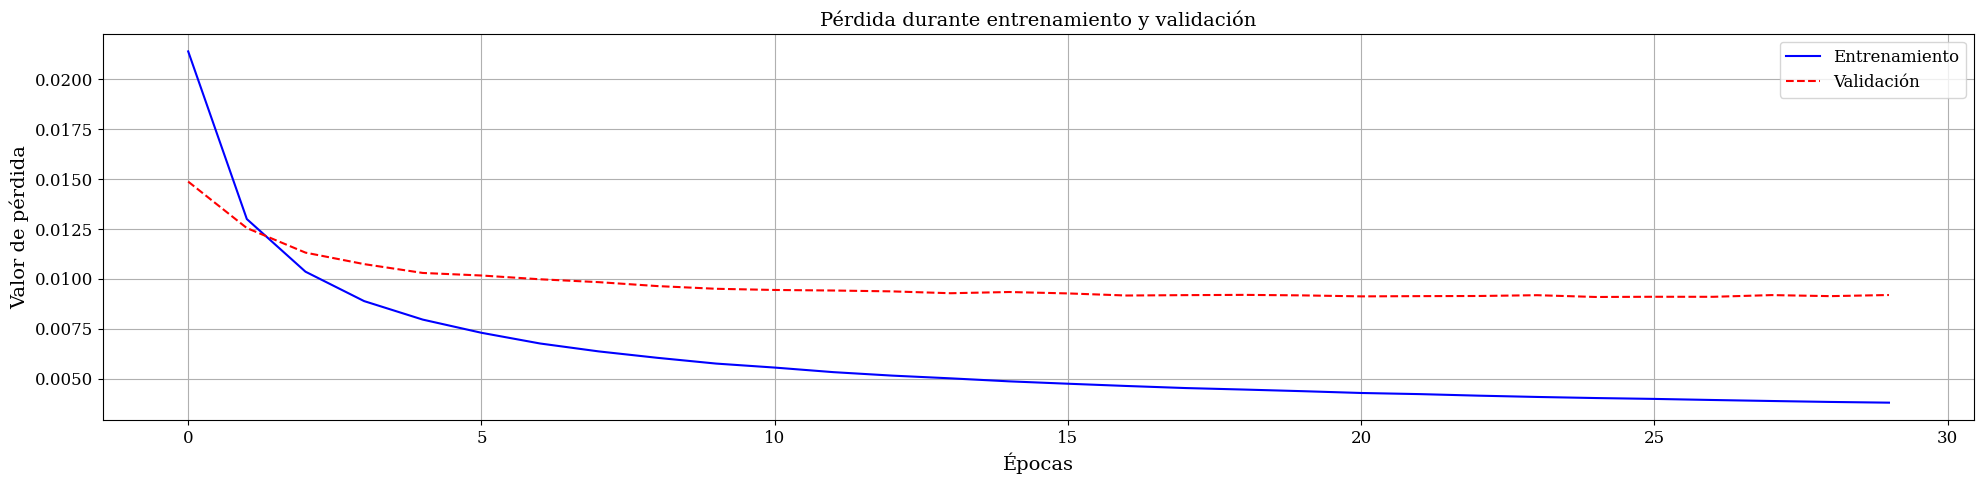

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.titlesize': 14,
    'axes.labelsize': 14
})

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(1, 1, figsize=(20, 5), layout='tight')

ax.plot(loss, color='blue', linestyle='-', label='Entrenamiento')
ax.plot(val_loss, color='red', linestyle='--', label='Validación')
ax.set_title('Pérdida durante entrenamiento y validación')
ax.set_ylabel('Valor de pérdida')
ax.set_xlabel('Épocas')
ax.legend(loc="upper right")
ax.grid()

plt.show()

In [ ]:
model.evaluate(X_test, y_test, batch_size=batch_size)

123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0091


0.008965728804469109

# Model to ONNX

In [ ]:
!pip install tf2onnx

In [ ]:
!pip install numpy==1.24


In [ ]:
import tensorflow as tf
import tf2onnx
import onnx

model = tf.keras.models.load_model("chess.keras")

input_signature = [tf.TensorSpec([1, 2, 769], tf.float32, name='x')]

onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)
onnx.save(onnx_model, "chess.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7f99df83f420>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


# Testing

In [ ]:
import chess
import gc
import numpy as np

def board_to_input(board):
  input_white = []
  input_black = []

  for color in chess.COLORS:
    for piece_type in chess.PIECE_TYPES:
      piece_map = board.pieces(piece_type, color)

      input_white.extend(piece_map.tolist())
      input_black.extend(piece_map.mirror().tolist())

  return np.array(input_white, dtype=np.bool), np.array(input_black, dtype=np.bool)

inputs = []
labels = []

for row in tqdm(data_list, total=data_len):
  board = chess.Board("rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b KQkq - 1 1")
  turn = board.turn
  print()
  print(board)
  print(turn)

  input_white, input_black = board_to_input(board)

  if turn == chess.WHITE:
    input_white = np.insert(input_white, 0, True)
    input_black = np.insert(input_black, 0, False)
  else:
    input_white = np.insert(input_white, 0, False)
    input_black = np.insert(input_black, 0, True)

  input_white_float = ([int(ele) for ele in input_white])
  input_white_str = "".join([str(ele) for ele in input_white_float])
  print(input_white_str)

  for i in range(12):
    print(input_white_str[((i * 64) + 1) : (((i + 1) * 64) + 1)])

  inputs.append([input_white, input_black])

  labels.append(row[1])
  break

  0%|          | 0/1000000 [00:00<?, ?it/s]


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B . R
False
0000000001111111100000000000000000000000000000000000000000000000001000000000000000000000100000000000000000000000000000000000000000010010000000000000000000000000000000000000000000000000000000000100000010000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111110000000000000000000000000000000000000000000000000000000000000000010000100000000000000000000000000000000000000000000000000000000000100100000000000000000000000000000000000000000000000000000000001000000100000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000001000
0000000011111111000000000000000000000000000000000000000000000000
010000000000000000000001000000

In [ ]:
import keras

model = keras.models.load_model("chess.keras")

In [ ]:
import numpy as np


position = np.array(inputs)
pred = model.predict(position)

inverse = np.log((pred / (1 - pred)))
cp = inverse * 400
print(inverse, cp)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[-0.05562647]] [[-22.250587]]
